<a href="https://colab.research.google.com/github/dmitryglhf/jupyter-projects/blob/main/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn

import copy
import tqdm

# First part

### Wolfe

In [2]:
def f(x):
    return 0.5 * (x[0]**2 + (x[0] - x[1])**2 + (x[1] - x[2])**2 + x[2]**2) - x[0]

In [3]:
# Аналитическое задание градиента
def grad_f(x):
    grad = np.zeros_like(x)
    grad[0] = 2 * x[0] - x[1] - 1  # производная по x1
    grad[1] = 2 * x[1] - x[0] - x[2]  # производная по x2
    grad[2] = 2 * x[2] - x[1]  # производная по x3
    return grad

In [4]:
# Численный градиент через конечные разности
def grad_kr(f, x, h=1e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x1 = np.copy(x)
        x2 = np.copy(x)
        x1[i] += h
        x2[i] -= h
        grad[i] = (f(x1) - f(x2)) / (2 * h)
    return grad

In [5]:
def wolfe(f, grad_f, x, p, alpha_max=1, c1=1e-4, c2=0.9, max_iter=100):
    def zoom(alpha_low, alpha_high):
        """Функция поиска шага с интерполяцией (zoom) по условиям Вольфе."""
        while True:
            alpha_j = 0.5 * (alpha_low + alpha_high)
            f_x_alpha_j = f(x + alpha_j * p)
            f_x_alpha_low = f(x + alpha_low * p)

            if (f_x_alpha_j > f(x) + c1 * alpha_j * np.dot(grad_f(x), p)) or (f_x_alpha_j >= f_x_alpha_low):
                alpha_high = alpha_j
            else:
                grad_f_x_alpha_j = np.dot(grad_f(x + alpha_j * p), p)

                if np.abs(grad_f_x_alpha_j) <= -c2 * np.dot(grad_f(x), p):
                    return alpha_j

                if grad_f_x_alpha_j * (alpha_high - alpha_low) >= 0:
                    alpha_high = alpha_low

                alpha_low = alpha_j

    # Начальные значения
    alpha_prev = 0
    alpha_curr = 0.5 * alpha_max
    i = 1

    while i <= max_iter:
        f_x_alpha_curr = f(x + alpha_curr * p)

        if (f_x_alpha_curr > f(x) + c1 * alpha_curr * np.dot(grad_f(x), p)) or (i > 1 and f_x_alpha_curr >= f(x + alpha_prev * p)):
            return zoom(alpha_prev, alpha_curr)

        grad_f_x_alpha_curr = np.dot(grad_f(x + alpha_curr * p), p)

        if np.abs(grad_f_x_alpha_curr) <= -c2 * np.dot(grad_f(x), p):
            return alpha_curr

        if grad_f_x_alpha_curr >= 0:
            return zoom(alpha_prev, alpha_curr)

        alpha_prev = alpha_curr
        alpha_curr = 0.5 * (alpha_curr + alpha_max)
        i += 1

    return alpha_curr

In [6]:
def wolfe_kr(f, grad_kr, x, p, alpha_max=1, c1=1e-4, c2=0.9, max_iter=100):
    def zoom(alpha_low, alpha_high):
        """Функция поиска шага с интерполяцией (zoom) по условиям Вольфе."""
        while True:
            alpha_j = 0.5 * (alpha_low + alpha_high)
            f_x_alpha_j = f(x + alpha_j * p)
            f_x_alpha_low = f(x + alpha_low * p)

            if (f_x_alpha_j > f(x) + c1 * alpha_j * np.dot(grad_kr(f,x), p)) or (f_x_alpha_j >= f_x_alpha_low):
                alpha_high = alpha_j
            else:
                grad_f_x_alpha_j = np.dot(grad_kr(f,x + alpha_j * p), p)

                if np.abs(grad_f_x_alpha_j) <= -c2 * np.dot(grad_kr(f,x), p):
                    return alpha_j

                if grad_f_x_alpha_j * (alpha_high - alpha_low) >= 0:
                    alpha_high = alpha_low

                alpha_low = alpha_j

    # Начальные значения
    alpha_prev = 0
    alpha_curr = 0.5 * alpha_max
    i = 1

    while i <= max_iter:
        f_x_alpha_curr = f(x + alpha_curr * p)

        if (f_x_alpha_curr > f(x) + c1 * alpha_curr * np.dot(grad_kr(f,x), p)) or (i > 1 and f_x_alpha_curr >= f(x + alpha_prev * p)):
            return zoom(alpha_prev, alpha_curr)

        grad_f_x_alpha_curr = np.dot(grad_kr(f,x + alpha_curr * p), p)

        if np.abs(grad_f_x_alpha_curr) <= -c2 * np.dot(grad_kr(f,x), p):
            return alpha_curr

        if grad_f_x_alpha_curr >= 0:
            return zoom(alpha_prev, alpha_curr)

        alpha_prev = alpha_curr
        alpha_curr = 0.5 * (alpha_curr + alpha_max)
        i += 1

    return alpha_curr

### BFGS

In [7]:
# Реализация алгоритма BFGS
def BFGS_grad_f(f, grad_f, x0, max_iter=100, tol=1e-5):
    x = np.copy(x0)
    H = np.eye(len(x0))  # Инициализация матрицы Гессе
    for i in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -np.dot(H, grad)  # Направление
        alpha = wolfe(f, grad_f, x, p)  # Линейный поиск
        x_new = x + alpha * p
        s = x_new - x
        y = grad_f(x_new) - grad
        rho = 1.0 / np.dot(y, s)
        H = (np.eye(len(x)) - rho * np.outer(s, y)).dot(H).dot(np.eye(len(x)) \
        - rho * np.outer(y, s)) + rho * np.outer(s, s)
        x = x_new
    return x


def BFGS_grad_kr(f, grad_kr, x0, max_iter=100, tol=1e-5):
    x = np.copy(x0)
    H = np.eye(len(x0))  # Инициализация матрицы Гессе
    for i in range(max_iter):
        grad = grad_kr(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -np.dot(H, grad)  # Направление
        alpha = wolfe(f, grad_kr, x, p)  # Линейный поиск
        x_new = x + alpha * p
        s = x_new - x
        y = grad_kr(x_new) - grad
        rho = 1.0 / np.dot(y, s)
        H = (np.eye(len(x)) - rho * np.outer(s, y)).dot(H).dot(np.eye(len(x)) \
        - rho * np.outer(y, s)) + rho * np.outer(s, s)
        x = x_new
    return x

### L-BFGS

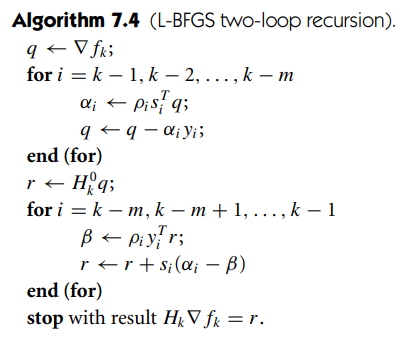

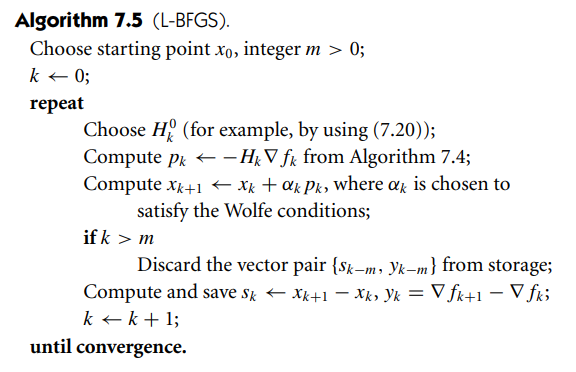/

In [8]:
def recursion_two_loop(gradient, s_stored, y_stored, m):
    """
    Реализует двухцикловую рекуррентную процедуру для вычисления направления p_k в L-BFGS.
    gradient: текущий градиент функции
    s_stored: матрица хранящихся изменений позиций (s_k)
    y_stored: матрица хранящихся изменений градиентов (y_k)
    m: количество хранящихся векторов s и y (глубина памяти)
    """
    q = gradient  # начальное значение q равно текущему градиенту
    a = np.zeros(m)  # массив коэффициентов alpha
    rou = np.array([1/np.dot(y_stored[j, :], s_stored[j, :]) for j in range(m)])  # коэффициенты rho

    # Первый цикл: обратное прохождение по векторам
    for i in range(m):
        a[m - 1 - i] = rou[m - 1 - i] * np.dot(s_stored[m - 1 - i, :], q)
        q = q - a[m - 1 - i] * y_stored[m - 1 - i, :]

    # Инициализация начальной аппроксимации матрицы Гессе
    H_k0 = np.dot(s_stored[m - 1], y_stored[m - 1]) / np.dot(y_stored[m - 1], y_stored[m - 1])
    r = H_k0 * q  # начальное направление

    # Второй цикл: прямое прохождение по векторам
    for i in range(m):
        beta = rou[i] * np.dot(y_stored[i, :], r)
        r = r + (a[i] - beta) * s_stored[i]

    return r  # результат - скорректированное направление


def L_BFGS_grad_f(f, x0, max_it=100, m=7):
    """
    Алгоритм L-BFGS для поиска минимума функции.
    f: функция, минимум которой ищется
    x0: начальная точка
    max_it: максимальное количество итераций
    m: количество хранимых изменений градиентов и позиций (глубина памяти)
    """
    d = len(x0)  # размерность задачи
    grad = grad_f(x0)  # начальный градиент в точке x0
    x = x0[:]  # текущая позиция (точка)
    x_store = np.array([x0])  # для хранения последовательности точек

    y_stored = []  # хранилище для векторов y_k
    s_stored = []  # хранилище для векторов s_k
    p = -grad  # начальное направление поиска - противоположное градиенту
    alpha = wolfe(f, grad_f, x, p)  # вычисление шага по направлению с помощью условия Вольфа
    s_stored.append(alpha * p)  # сохраняем изменение позиции
    grad_old = grad[:]  # сохраняем старый градиент
    x = x + alpha * p  # обновляем позицию
    grad = grad_f(x)  # вычисляем новый градиент
    y_stored.append(grad - grad_old)  # сохраняем изменение градиента
    m_ = 1  # начальное количество хранимых векторов (<= m)
    it = 1  # текущий номер итерации

    x_store = np.append(x_store, [x], axis=0)  # обновление истории точек

    # Основной цикл оптимизации
    while np.linalg.norm(grad) > 1e-5:  # условие завершения по норме градиента
        if it > max_it:  # прерывание, если достигнуто максимальное число итераций
            break

        if 0 < it < m:  # начальная фаза, когда храним меньше m векторов
            p = -recursion_two_loop(grad, np.array(s_stored), np.array(y_stored), m_)
            alpha = wolfe(f,  grad_f, x, p)  # шаг по условию Вольфа
            s_stored.append(alpha * p)  # сохраняем изменение позиции
            grad_old = grad[:]  # сохраняем старый градиент
            x = x + alpha * p  # обновляем позицию
            grad = grad_f(x)  # вычисляем новый градиент
            y_stored.append(grad - grad_old)  # сохраняем изменение градиента
            m_ += 1  # увеличиваем число хранимых векторов
            it += 1  # увеличиваем счетчик итераций
            x_store = np.append(x_store, [x], axis=0)  # обновление истории точек
        else:  # основная фаза, когда храним m векторов
            p = -recursion_two_loop(grad, np.array(s_stored), np.array(y_stored), m)
            alpha = wolfe(f,  grad_f, x, p)

            # обновляем и сохраняем вектор s_k+1
            s_stored.append(alpha * p)
            s_stored.pop(0)  # удаляем старейший вектор, чтобы хранить ровно m векторов

            grad_old = grad[:]  # сохраняем старый градиент
            x = x + alpha * p  # обновляем позицию
            grad = grad_f(x)  # вычисляем новый градиент

            # обновляем и сохраняем вектор y_k+1
            y_stored.append(grad - grad_old)
            y_stored.pop(0)  # удаляем старейший вектор y, чтобы хранить ровно m векторов
            it += 1  # увеличиваем счетчик итераций

            x_store = np.append(x_store, [x], axis=0)  # обновление истории точек

    return x  # возвращаем последнюю точек


def L_BFGS_grad_kr(f, x0, max_it=100, m=7):
    """
    Алгоритм L-BFGS для поиска минимума функции.
    f: функция, минимум которой ищется
    x0: начальная точка
    max_it: максимальное количество итераций
    m: количество хранимых изменений градиентов и позиций (глубина памяти)
    """
    d = len(x0)  # размерность задачи
    grad = grad_kr(f, x0)  # начальный градиент в точке x0
    x = x0[:]  # текущая позиция (точка)
    x_store = np.array([x0])  # для хранения последовательности точек

    y_stored = []  # хранилище для векторов y_k
    s_stored = []  # хранилище для векторов s_k
    p = -grad  # начальное направление поиска - противоположное градиенту
    alpha = wolfe_kr(f,  grad_kr, x, p)  # вычисление шага по направлению с помощью условия Вольфа
    s_stored.append(alpha * p)  # сохраняем изменение позиции
    grad_old = grad[:]  # сохраняем старый градиент
    x = x + alpha * p  # обновляем позицию
    grad = grad_kr(f, x)  # вычисляем новый градиент
    y_stored.append(grad - grad_old)  # сохраняем изменение градиента
    m_ = 1  # начальное количество хранимых векторов (<= m)
    it = 1  # текущий номер итерации

    x_store = np.append(x_store, [x], axis=0)  # обновление истории точек

    # Основной цикл оптимизации
    while np.linalg.norm(grad) > 1e-5:  # условие завершения по норме градиента
        if it > max_it:  # прерывание, если достигнуто максимальное число итераций
            break

        if 0 < it < m:  # начальная фаза, когда храним меньше m векторов
            p = -recursion_two_loop(grad, np.array(s_stored), np.array(y_stored), m_)
            alpha = wolfe_kr(f,  grad_kr, x, p)  # шаг по условию Вольфа
            s_stored.append(alpha * p)  # сохраняем изменение позиции
            grad_old = grad[:]  # сохраняем старый градиент
            x = x + alpha * p  # обновляем позицию
            grad = grad_kr(f, x)  # вычисляем новый градиент
            y_stored.append(grad - grad_old)  # сохраняем изменение градиента
            m_ += 1  # увеличиваем число хранимых векторов
            it += 1  # увеличиваем счетчик итераций
            x_store = np.append(x_store, [x], axis=0)  # обновление истории точек
        else:  # основная фаза, когда храним m векторов
            p = -recursion_two_loop(grad, np.array(s_stored), np.array(y_stored), m)
            alpha = wolfe_kr(f,  grad_kr, x, p)

            # обновляем и сохраняем вектор s_k+1
            s_stored.append(alpha * p)
            s_stored.pop(0)  # удаляем старейший вектор, чтобы хранить ровно m векторов

            grad_old = grad[:]  # сохраняем старый градиент
            x = x + alpha * p  # обновляем позицию
            grad = grad_kr(f, x)  # вычисляем новый градиент

            # обновляем и сохраняем вектор y_k+1
            y_stored.append(grad - grad_old)
            y_stored.pop(0)  # удаляем старейший вектор y, чтобы хранить ровно m векторов
            it += 1  # увеличиваем счетчик итераций

            x_store = np.append(x_store, [x], axis=0)  # обновление истории точек

    return x # возвращаем последнюю точку

### BFGS and L-BFGS comparison

In [9]:
x0=[0.0, 0.0, 0.0]

# BFGS
bfgs_result_analit= BFGS_grad_f(f, lambda x: grad_f(x) ,x0 )
bfgs_result_kr = BFGS_grad_kr(f, lambda x: grad_kr(f,x) ,x0 )

# L-BFGS
f_lbfgs_f = L_BFGS_grad_f(f, x0)
f_lbfgs_kr = L_BFGS_grad_kr(f, x0)

print("BFGS аналит вычисляем градиент при x =", bfgs_result_analit)
print("BFGS конечно-разностно вычисляем градиент при x =", bfgs_result_kr)
print("LBFGS аналит вычисляем градиент при x =", f_lbfgs_f)
print("LBFGS конечно-разностно вычисляем градиент  при x =", f_lbfgs_kr)

BFGS аналит вычисляем градиент при x = [0.74999704 0.49999409 0.24999491]
BFGS конечно-разностно вычисляем градиент при x = [0.74999704 0.49999409 0.24999491]
LBFGS аналит вычисляем градиент при x = [0.74999396 0.49999259 0.24999193]
LBFGS конечно-разностно вычисляем градиент  при x = [0.74999396 0.49999259 0.24999193]


# Second part

### Adam

https://medium.com/@weidagang/demystifying-the-adam-optimizer-in-machine-learning-4401d162cb9e

- Initialize the model parameters (θ), learning rate (α), and hyper-parameters (β1, β2, and ε).
- Compute the gradients (g) of the loss function (L) with respect to the model parameters.

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*mZ3WT9OfmrmTv6cnmqccRA@2x.png)
- Update the first moment estimates (m):

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*dnP88VVt0pcvcU7RQTkbTA@2x.png)
- Update the second moment estimates (v):

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*DwCaL4CKgwE3JzZFlE_How@2x.png)
- Correct the bias in the first (m_hat) and second (v_hat) moment estimates for the current iteration (t):

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*6ZhL15mh0zLSsqWlaYkP1g@2x.png)
- Compute the adaptive learning rates (α_t):

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*To-rkzCyP06vNQYr7EGQAQ@2x.png)
- Update the model parameters using the adaptive learning rates:

![](https://miro.medium.com/v2/resize:fit:400/format:webp/1*y3O6rfmIiTEPtBwDRq7Zqg@2x.png)


In [10]:
def Adam(params, grads, m, v, t, alpha=0.001, b1=0.9, b2=0.999, e=1e-8):
    # Обновление моментов и параметров
    for i, (param, grad) in enumerate(zip(params, grads)):
        m[i] = b1 * m[i] + (1 - b1) * grad
        v[i] = b2 * v[i] + (1 - b2) * grad ** 2

        m_hat = m[i] / (1 - b1 ** t)
        v_hat = v[i] / (1 - b2 ** t)

        # Обновляем параметры
        param.data -= alpha * m_hat / (torch.sqrt(v_hat) + e)

### Build network

In [11]:
class MyNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.hidden = nn.Linear(n, n)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

###### Adam network

In [12]:
def model_train_adam(model, X_train, y_train, X_val, y_val, n_epochs=100):
    # Определяем функцию потерь
    loss_fn = nn.BCELoss()
    batch_size = 10
    batch_start = np.arange(0, len(X_train), batch_size)

    best_acc = -np.inf
    best_weights = None

    params = list(model.parameters())
    m = [torch.zeros_like(p) for p in params]
    v = [torch.zeros_like(p) for p in params]
    t = 0  # счетчик времени

    for epoch in range(n_epochs):
        model.train()
        for start in batch_start:
            X_batch = X_train[start:start + batch_size]
            y_batch = y_train[start:start + batch_size]

            X_batch = torch.tensor(X_batch.values, dtype=torch.float32)
            y_batch = torch.tensor(y_batch.values, dtype=torch.float32).view(-1, 1)

            # Прямой проход (forward pass)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # Обратное распространение ошибки
            loss.backward()

            # Вычисляем градиенты
            grads = [p.grad for p in params]

            # Обновляем параметры через Adam
            t += 1
            Adam(params, grads, m, v, t, alpha=0.0001)

            # Обнуляем градиенты после обновления
            model.zero_grad()

        # Оценка точности валидационного набора
        model.eval()
        y_pred_val = model(torch.tensor(X_val.values, dtype=torch.float32))
        acc = ((y_pred_val.round() == torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)).float().mean()).item()

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    return best_acc

###### BFGS network

In [13]:
def model_train_bfgs(model, X_train, y_train, X_val, y_val, n_epochs=100, tol=1e-5):
    # Define loss function
    loss_fn = nn.BCELoss()
    best_acc = -np.inf
    best_weights = None

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # Function to compute loss
    def f(x):
        # Reshape x into model parameters
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                param_size = param.numel()
                param.copy_(torch.tensor(x[start:start + param_size]).reshape(param.shape))
                start += param_size

        # Forward pass
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        return loss.item()

    # Function to compute gradient
    def grad_kr(x):
        # Reshape x into model parameters
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                param_size = param.numel()
                param.copy_(torch.tensor(x[start:start + param_size]).reshape(param.shape))
                start += param_size

        # Forward and backward passes
        model.zero_grad()
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        loss.backward()

        # Collect gradients
        grad = []
        for param in model.parameters():
            grad.append(param.grad.numpy().flatten())
        return np.concatenate(grad)

    for epoch in range(n_epochs):
        model.train()

        # Get current parameters as numpy array
        x0 = []
        for param in model.parameters():
            x0.append(param.detach().numpy().flatten())
        x0 = np.concatenate(x0)

        # Optimize using BFGS
        x_opt = BFGS_grad_kr(f, grad_kr, x0, tol=tol)

        # Update model parameters with optimized values
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                param_size = param.numel()
                param.copy_(torch.tensor(x_opt[start:start + param_size]).reshape(param.shape))
                start += param_size

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val_tensor)
            acc = ((y_pred_val.round() == y_val_tensor).float().mean()).item()

        # Save best model
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    # Load best weights
    model.load_state_dict(best_weights)
    return best_acc

###### L-BFGS network

In [14]:
import torch
import numpy as np
import copy

def model_train_lbfgs(model, X_train, y_train, X_val, y_val, n_epochs=100, m=7, tol=1e-5):
    # Define loss function
    loss_fn = nn.BCELoss()
    best_acc = -np.inf
    best_weights = None

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # Function to compute loss for L-BFGS
    def f(x):
        # Reshape x into model parameters
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                param_size = param.numel()
                param.copy_(torch.tensor(x[start:start + param_size]).reshape(param.shape))
                start += param_size

        # Forward pass
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        return loss.item()

    # Function to get current parameters as numpy array
    def get_params():
        params = []
        for param in model.parameters():
            params.append(param.detach().numpy().flatten())
        return np.concatenate(params)

    # Function to set parameters from numpy array
    def set_params(x):
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                param_size = param.numel()
                param.copy_(torch.tensor(x[start:start + param_size]).reshape(param.shape))
                start += param_size

    for epoch in range(n_epochs):
        model.train()

        # Get current parameters as numpy array
        x0 = get_params()

        # Optimize using L-BFGS
        x_opt = L_BFGS_grad_kr(f, x0, max_it=100, m=m)

        # Update model parameters with optimized values
        set_params(x_opt)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val_tensor)
            acc = ((y_pred_val.round() == y_val_tensor).float().mean()).item()

            # Compute current loss
            y_pred_train = model(X_train_tensor)
            current_loss = loss_fn(y_pred_train, y_train_tensor).item()

        # Save best model
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

        # Early stopping based on loss
        if current_loss < tol:
            break

    # Load best weights
    model.load_state_dict(best_weights)
    return best_acc

### Data

In [15]:
df = pd.read_csv('/content/Cancer_Data.csv')

# to binary
encoder = LabelEncoder()
df["diagnosis"] = encoder.fit_transform(df["diagnosis"])

# clear data
columns_to_drop = ['id', 'Unnamed: 32']
df.drop(columns_to_drop, axis=1, inplace=True)

# 150
df = df.head(150)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# кол-во признаков
n = X.shape[1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

### Results

In [17]:
model_adam = MyNN(n)
model_bfgs = MyNN(n)
model_lbfgs = MyNN(n)

In [18]:
# Adam optimizer
adam_acc = model_train_adam(model_adam, X_train, y_train, X_test, y_test, n_epochs=100)
print(f"Best Adam accuracy: {adam_acc*100:.2f}%")

Best Adam accuracy: 93.33%


In [ ]:
# BFGS optimizer
bfgs_acc = model_train_bfgs(model_bfgs, X_train, y_train, X_test, y_test, n_epochs=100)
print(f"Best BFGS accuracy: {bfgs_acc*100:.2f}%")

In [ ]:
# L-BFGS optimizer
lbfgs_acc = model_train_lbfgs(model_lbfgs, X_train, y_train, X_test, y_test, n_epochs=100)
print(f"Best L-BFGS accuracy: {lbfgs_acc*100:.2f}%")

BFGS:
- Быстро сходится на небольших задачах, но требует много памяти.
- Чувствителен к плохой начальной точке.

L-BFGS:
- Подходит для больших задач, так как использует ограниченную память.
- Требует настройки параметра количества хранимых градиентов (memory).

Adam:
- Подходит для задач с большими наборами данных или шумными функциями потерь.
- Чувствителен к выбору коэффициента обучения.
- Моментные коэффициенты могут повлиять на скорость сходимости.

Таким образом, основное сравнение сводится к тому, что Adam гораздо лучше подходит для больших сетей и сложных задач, в то время как L-BFGS (и тем более BFGS) могут быть полезны для более простых моделей и небольших задач, где требуется высокая точность в оптимизации.